In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.file_readers import phi_wrap, pandas_to_unclustered_particles, get_highest_mass_constituents, pandas_to_features, select_jets
from modules.jet_augs import rotate_jet_vectorized, distort_jet_vectorized, normalise_pt_vectorized, rescale_pt_vectorized, crop_jet_vectorized, translate_jet_vectorized
from modules.transformer import Transformer
from modules.neural_net import create_and_run_nn
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test 

# tables
!{sys.executable} -m pip install tables

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "lmwt_wlct_wnn_2"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/u1/r/rmastand/JetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: lmwt_wlct_wnn_2


# Load in the data

Starts with a dataset of particles $p_T$, $\eta$, $\phi$

Clusters into jets, takes highest mass jet, returns the constituents ordered by pT

Dataset shape: (n,3,101) = (n,[$p_T$, $\eta$, $\phi$],1 jet + 100 constituents)

In [3]:
clustered_npy_exists = True

path_to_unclustered = "/global/project/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"

if not clustered_npy_exists:
    
    start = 65000
    stop = 70000
    jetR = 0.8
    
    fname_data = "02092021/highmassconstits_data_jetR_"+str(jetR)+"_deltaJ_"+str(start)+"_"+str(stop)+".npy"
    fname_labels = "02092021/highmassconstits_labels_jetR_"+str(jetR)+"_deltaJ_"+str(start)+"_"+str(stop)+".npy"
    
    print("Reading in unclustered events...")
    # Read in the file
    unclustered_particles_data = pd.read_hdf(path_to_unclustered,start = start, stop = stop)
    # Convert pd to numpy; get labels
    unclustered_collisions, unclustered_particles_labels = pandas_to_unclustered_particles(unclustered_particles_data)

    # Cluster into jets, get highest mass constituents
    high_mass_consits, bad_indices = get_highest_mass_constituents(unclustered_collisions, jetR, deltaJ = True, ncon_store=101)

    unclustered_particles_labels = np.delete(unclustered_particles_labels,bad_indices)
    np.save("processed_data/"+fname_data, high_mass_consits)
    np.save("processed_data/"+fname_labels, unclustered_particles_labels)
    print("Saved file "+fname_data)
    print("Saved file "+fname_labels)
    
    print(high_mass_consits.shape,unclustered_particles_labels.shape)

    
if clustered_npy_exists: 
    
    jetR = 0.8
    """
    starts_and_stops = [(0,2000),(2000,4000),(4000,6000),(6000,8000),(8000,10000),
                       (10000,12000),(12000,14000),(14000,16000),(16000,18000),(18000,20000),
                       (20000,22000),(22000,24000),(24000,26000),(26000,28000),(28000,30000),
                       (30000,32000),(32000,34000),(34000,36000),(36000,38000),(38000,40000)]
    """
    
    starts_and_stops = [(0,5000),(5000,10000),(10000,15000),(15000,20000),
                       (20000,25000),(25000,30000),(30000,35000),(35000,40000),
                       (40000,45000),(45000,50000),(50000,55000),(55000,60000),
                       (60000,65000),(65000,70000)]
    



    high_mass_consits_wjet = np.load("processed_data/02092021/highmassconstits_data_jetR_"+str(jetR)+"_deltaJ_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")
    high_mass_labels = np.load("processed_data/02092021/highmassconstits_labels_jetR_"+str(jetR)+"_deltaJ_"+str(starts_and_stops[0][0])+"_"+str(starts_and_stops[0][1])+".npy")

    for ss in starts_and_stops[1:]:
        high_mass_consits_wjet = np.concatenate([high_mass_consits_wjet, np.load("processed_data/02092021/highmassconstits_data_jetR_"+str(jetR)+"_deltaJ_"+str(ss[0])+"_"+str(ss[1])+".npy")])
        high_mass_labels = np.concatenate([high_mass_labels, np.load("processed_data/02092021/highmassconstits_labels_jetR_"+str(jetR)+"_deltaJ_"+str(ss[0])+"_"+str(ss[1])+".npy")])
        
    print("Read in files")
    print("Data shape: ",high_mass_consits_wjet.shape)
    print("Labels shape:", high_mass_labels.shape)
          

Read in files
Data shape:  (69995, 3, 101)
Labels shape: (69995,)


## Jet cuts 

Cut on $p_t$, $\eta$ of the jets 

Then split into signal and background datasets

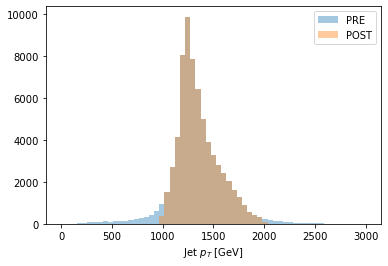

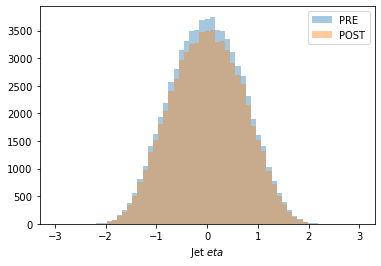

In [4]:
# Select jets of interest

# Make the cut
pt_cut = [1000,2000]
eta_cut = [-2,2]
high_mass_consits_wjet_cut, high_mass_labels_cut = select_jets(high_mass_consits_wjet, high_mass_labels, pt_cut, eta_cut)


# plot the jet parameters
plt.figure()
plt.hist(high_mass_consits_wjet[:,0,0], bins = np.linspace(0,3000,60), alpha = 0.4, label = "PRE")
plt.hist(high_mass_consits_wjet_cut[:,0,0], bins = np.linspace(0,3000,60), alpha = 0.4, label = "POST")
plt.legend()
plt.xlabel("Jet $p_T$ [GeV]")
plt.show()

# plot the jet parameters
plt.figure()
plt.hist(high_mass_consits_wjet[:,1,0], bins = np.linspace(-3,3,60), alpha = 0.4, label = "PRE")
plt.hist(high_mass_consits_wjet_cut[:,1,0], bins = np.linspace(-3,3,60), alpha = 0.4, label = "POST")
plt.legend()
plt.xlabel("Jet $eta$")
plt.show()


In [6]:
# Take only the constituents (i.e. drop the 0th, which is the jet)
high_mass_consits = high_mass_consits_wjet_cut[:,:,1:]

# get max, min pt for normalizing
max_pt = np.max(high_mass_consits[:,0,:])
max_eta = np.max(high_mass_consits[:,1,:])
max_phi = np.max(high_mass_consits[:,2,:])
                  
print("Max pt:",max_pt,"; max eta:", max_eta, "; max phi:", max_phi)

# split into signal vs background

high_mass_consits_sig = high_mass_consits[np.where(high_mass_labels_cut==1)]
high_mass_consits_bkg = high_mass_consits[np.where(high_mass_labels_cut==0)]

print("Signal shape:", high_mass_consits_sig.shape)
print("Background shape:", high_mass_consits_bkg.shape)


rescale_denom_pt = max_pt/10
#rescale_denom_pt = 1

Max pt: 1697.4986572265625 ; max eta: 1.1200144211507095 ; max phi: 1.1434103923217482
Signal shape: (6104, 3, 100)
Background shape: (59337, 3, 100)


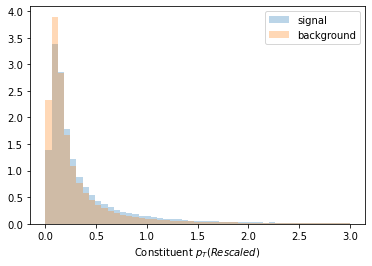

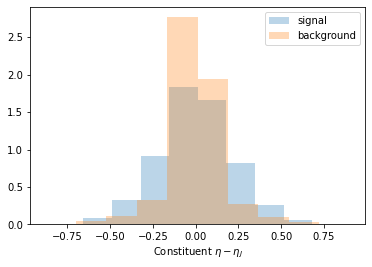

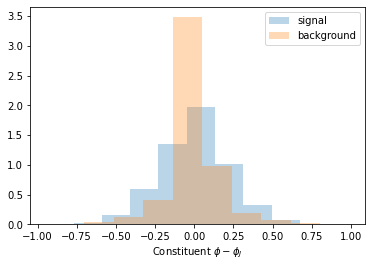

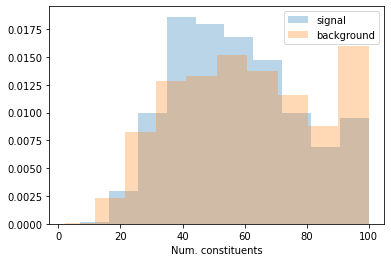

In [8]:
# Plots of pt, eta, phi for the constituents

N_start = 0  # Number of collision events
N_stop = 70000

M = 20  # Number of constituents


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,0,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/rescale_denom_pt, bins = np.linspace(0,3,50), alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,0,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0]/rescale_denom_pt, bins = np.linspace(0,3,50), alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $p_T (Rescaled)$")
#plt.xlim(0,5000)
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,1,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\eta-\eta_J$")
plt.legend()
plt.show()


plt.figure()
loc_plot = np.reshape(high_mass_consits_sig[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "signal")
loc_plot = np.reshape(high_mass_consits_bkg[N_start:N_stop,2,0:M],((N_start-N_stop)*(M),))
plt.hist(loc_plot[loc_plot != 0], alpha = .3, density=True, label = "background")
plt.xlabel("Constituent $\phi-\phi_J$")
plt.legend()
plt.show()


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(100-len(pads[0]))
        
    return consits_list
        


plt.figure()
plt.hist(get_num_constits(high_mass_consits_sig), alpha = .3, density=True, label = "signal")
plt.hist(get_num_constits(high_mass_consits_bkg), alpha = .3, density=True, label = "background")
plt.xlabel("Num. constituents")
plt.legend()
plt.show()





# Split the data into test / train / validation sets

- CLR training: First ```num_clr_train``` background events
- CLR val: 20% of CLR train

- Classification training: (up to) ```njets_sig``` signal, ```njets_bkg``` background
- Classification test: 30% of training
- Classification test is further split into validation / test



In [9]:
# input dim to the transformer -> (pt,eta,phi)
input_dim = 3

# creating the training dataset

n_constits_max = 20
grading = 20

datasets_num_constits = {i:0 for i in range(grading,n_constits_max+grading,grading)}

"""
RUN THE JET SELECTOR CODE
"""


for n_constits_considered in range(grading,n_constits_max+grading,grading):
    t0 = time.time()
    
    """
    Make the CLR train and val datasets
    """
    num_clr_train = 15000
    val_size = 0.2
    dataset_clr = high_mass_consits_bkg[0:num_clr_train,:,0:n_constits_considered]
    
    ((clr_train, clr_val),
     ) = [train_test_split(arr, test_size=val_size) for arr in [
        dataset_clr,
    ]]
    
    """
    Make the classification datasets
    """
    njets_sig = 7000
    njets_bkg = 12000
    
    # take only however many constituents and jets we want 
    dataset_sample_sig = high_mass_consits_sig[0:njets_sig,:,0:n_constits_considered]
    dataset_sample_bkg = high_mass_consits_bkg[num_clr_train:njets_bkg+num_clr_train,:,0:n_constits_considered]
    
    print("Num signal:", dataset_sample_sig.shape[0],"; Num background:", dataset_sample_bkg.shape[0])
    
    test_size = .3
    ((sig_train, sig_test),
     (bkg_train, bkg_test),
     ) = [train_test_split(arr, test_size=test_size) for arr in [
        dataset_sample_sig,
        dataset_sample_bkg,
    ]]
    
    # preparing the training dataset w/ labels
    data_train = np.concatenate([sig_train,bkg_train])
    labels_train = np.concatenate([np.ones(sig_train.shape[0]),np.zeros(bkg_train.shape[0])])
    data_train, labels_train = shuffle(data_train, labels_train)
    
    # preparing the test dataset(s)
    data_test = np.concatenate([sig_test,bkg_test])
    labels_test = np.concatenate([np.ones(sig_test.shape[0]),np.zeros(bkg_test.shape[0])])
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Split the test into val + "testf"
    lct_val_size = .5
    n_val = int(data_test.shape[0]*lct_val_size)
    data_val = data_test[0:n_val,:,:]
    labels_val = labels_test[0:n_val]
    data_test_f = data_test[-n_val:,:,:]
    labels_test_f = labels_test[-n_val:]

    # print data dimensions
    print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
    print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
    print( "BC training data shape: " + str( data_train.shape ), flush=True)
    print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
    print( "BC val data shape: " + str( data_val.shape ), flush=True)
    print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
    print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
    print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)

    
    datasets_num_constits[n_constits_considered] = clr_train, clr_val, data_train, labels_train, data_val, labels_val,  data_test_f, labels_test_f
    
    t1 = time.time()

    print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds", flush=True  )
    print()

Num signal: 6104 ; Num background: 12000
CLR training data shape: (12000, 3, 20)
CLR val data shape: (3000, 3, 20)
BC training data shape: (12672, 3, 20)
BC training labels shape: (12672,)
BC val data shape: (2716, 3, 20)
BC val labels shape: (2716,)
BC test data shape: (2716, 3, 20)
BC test labels shape: (2716,)
time taken to load and preprocess data: 0.03 seconds



# Define the Neural Net

Basically the "constituents representation"

In [10]:
# NN hyperparams -- will be used multiple times

num_epochs_nn = 200
batch_size_nn = 400
#input_shape = 3*n_constits_considered
update_epochs_nn = 20
lr_nn = 0.0005

# Define the Transformer Net

In [ ]:
"""
Define the transformer net
"""

# transformer hyperparams
model_dim = 1000
output_dim = 1000
n_heads = 4
dim_feedforward = 1000
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.00005
batch_size = 256
temperature = 0.2

# augmentations
rot = True 
ptd = False  # low pT noise
ptcm = 0.001
ptst = 0.1
trs = False #translations
fill = False

net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

## send network to device
net.to( device )

# define lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( net.optimizer, factor=0.2 )


In [ ]:
# THE TRAINING LOOP

# initialise lists for storing training stats, validation loss
losses_clr_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
losses_clr_numer_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
losses_clr_denom_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
loss_validation_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss
lct_auc_num_jets = {i:[[],[],[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, auc (pt, eta, phi)
nn_auc_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, auc


n_epochs = 50
loss_check_epoch = 10
verbal_epoch = 5

for constit_num in range(grading,n_constits_max+grading,grading):
    
    t0 = time.time()

    print( "starting training loop, running for " + str( n_epochs ) + " epochs" + " with " + str(constit_num) + " constituents" 
          , flush=True)
    print("Training data shape:",clr_train.shape)
    print("Validation data shape:",clr_val.shape)
    print("BC training data shape:",data_train.shape)
    print("BC val data shape:",data_val.shape)
    print("BC test data shape:",data_test_f.shape)
    print( "---", flush=True )
    
    # re-batch the data on each epoch
    clr_train, clr_val,data_train, labels_train,data_val, labels_val,data_test_f, labels_test_f = datasets_num_constits[constit_num]

    for epoch in range( n_epochs + 1 ):
 
        # get batch_size number of indices
        indices_list = torch.split( torch.randperm( clr_train.shape[0] ), batch_size )

        # initialise lists to store batch stats
        losses_clr_e = []
        losses_clr_numer_e = []
        losses_clr_denom_e = []

        # the inner loop goes through the dataset batch by batch
        # augmentations of the jets are done on the fly
        for i, indices in enumerate( indices_list ): # random jets from the dataset
            net.optimizer.zero_grad()
            """
            TRANSFORMATIONS AND DATA PREPARATION
            """
            x_i = clr_train[indices,:,:]
            x_j = x_i.copy()
            if rot:
                x_j = rotate_jet_vectorized( x_j )
            if ptd:
                x_j = distort_jet_vectorized( x_j )
            if trs:
                x_j = translate_jets_vectorized( x_j )
                x_i = translate_jets_vectorized( x_i )
            x_i = rescale_pt_vectorized( x_i, rescale_denom_pt ) # shape (batchsize, 3, 2)
            x_j = rescale_pt_vectorized( x_j, rescale_denom_pt)
            x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
            x_j = torch.Tensor( x_j ).transpose(1,2).to( device )
            z_i = net( x_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
            z_j = net( x_j, use_mask=mask, use_continuous_mask=cmask )

            """
            LOSS CALCULATIONS
            """            
            # compute the loss based on predictions of the net and the correct answers
            loss = contrastive_loss( z_i, z_j, device, temperature, 1 ).to( device )
            [loss_numer, loss_denom] = [l.detach().cpu().numpy()  for l in contrastive_loss_num_den( z_i, z_j, device, temperature )]
            loss.backward()
            net.optimizer.step()
            net.optimizer.zero_grad()
            losses_clr_e.append( loss.detach().cpu().numpy() )
            losses_clr_numer_e.append(loss_numer)
            losses_clr_denom_e.append(loss_denom)

        """
        AVERAGING OF LOSSES
        """ 
        loss_clr_e = np.mean( np.array( losses_clr_e ) )
        ## scheduler
        scheduler.step( loss_clr_e )
        
        # storage
        losses_clr_num_jets[constit_num].append( loss_clr_e )
        losses_clr_numer_num_jets[constit_num].append( np.mean( np.array( losses_clr_numer_e ) ) )
        losses_clr_denom_num_jets[constit_num].append( np.mean( np.array( losses_clr_denom_e ) ) )
     
        """
        EVERY SO OFTEN, GIVEN AN UPDATE
        """

        if epoch % verbal_epoch == 0:
            

            print( "epoch: " + str( epoch ) + ", loss: " + str( round(losses_clr_num_jets[constit_num][-1], 5) ), flush=True )
            #print( "lr: " + str( scheduler._last_lr ), flush=True  )
            # summarize alignment and uniformity stats
            print( "numerator: " + str( losses_clr_numer_num_jets[constit_num][-1] ) + ", denominator: " + str( losses_clr_denom_num_jets[constit_num][-1] ), flush=True)
            print("time taken up to now: " + str(time.time()-t0))
            print()
            
        if epoch % loss_check_epoch == 0:
            
            """
            Get the validation loss
            """
            print("Getting the validation CLR loss...")
            # store the epoch
            loss_validation_num_jets[constit_num][0].append(epoch)
            
            with torch.no_grad():
                net.eval()
            
                # get batch_size number of indices
                indices_list_val = torch.split( torch.randperm( clr_val.shape[0] ), batch_size )
                local_val_losses = []

                for j, indices_val in enumerate( indices_list_val ):
                    a_i = clr_val[indices_val,:,:]
                    a_j = a_i.copy()
                    if rot:
                        a_j = rotate_jet_vectorized( a_j )
                    if ptd:
                        a_j = distort_jet_vectorized( a_j )
                    if trs:
                        a_j = translate_jets_vectorized( a_j )
                        a_i = translate_jets_vectorized( a_i )

                    a_i = rescale_pt_vectorized( a_i, rescale_denom_pt ) # shape (batchsize, 3, 2)
                    a_j = rescale_pt_vectorized( a_j, rescale_denom_pt)
                    a_i = torch.Tensor( a_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                    a_j = torch.Tensor( a_j ).transpose(1,2).to( device )
                    w_i = net( a_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
                    w_j = net( a_j, use_mask=mask, use_continuous_mask=cmask )

                    loss_val = contrastive_loss( w_i, w_j, device, temperature, 1 ).to( device )
                    local_val_losses.append(loss_val.detach().cpu().numpy())

                loss_val_e = np.mean( np.array( local_val_losses ) )
                loss_validation_num_jets[constit_num][1].append(loss_val_e)
            
            """
            Run a LCT + NN for signal vs background (supervised)
            """
            
            net.eval()
            lct_train_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_train ).transpose(1,2), data_train.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
            lct_test_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
            
            
            print("Doing a short LCT...")
            
            lct_auc_num_jets[constit_num][0].append(epoch)
            # Need to transform the data into the representation space first
            with torch.no_grad():
                for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
                    # run the LCT
                    reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_train)
                    # make the prediction
                    predictions = reg.predict(lct_test_reps[:,trait,:])
                    auc = roc_auc_score(labels_val, predictions)
                    lct_auc_num_jets[constit_num][1+trait].append(auc)
            
            print("Doing a short NN...")
            # CURRENTLY DOING VAL AND TEST WITH THE SAME DATA -- VERY VERY BAD
            nn_auc_num_jets[constit_num][0].append(epoch)
            # run on the data and evaluate
            input_shape = 3*model_dim
            #update_epochs_nn = 20
            #num_epochs_nn = 200
            #batch_size_nn = 400
            #lr_nn = 0.0003
    
            performance_stats_nn = create_and_run_nn(input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn, lr_nn, 
                                         lct_train_reps, labels_train, 
                      lct_test_reps, labels_val,
                      lct_test_reps, labels_val, False)
        
        
            plt.figure()
            plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"])
            plt.xlabel("Epochs")
            plt.ylabel("Losses")
            plt.yscale("log")
            plt.show()

            plt.figure()
            plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"])
            plt.xlabel("Epochs")
            plt.ylabel("Validation losses")
            plt.yscale("log")
            plt.show()


            plt.figure()
            plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
            plt.yscale("log")
            plt.xlabel("True Positive Rate")
            plt.ylabel("1/(False Positive Rate)")
            plt.show()

            print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
            print("ROC AUC:", performance_stats_nn["auc"])

            nn_auc_num_jets[constit_num][1].append(performance_stats_nn["auc"])
            print()
                
        
    t1 = time.time()

    print( "JETCLR TRAINING DONE, time taken: " + str( np.round( t1-t0, 2 ) ), flush=True)
    

    # save out results
    print( "saving out data/results", flush=True)
    np.save( expt_dir+"clr_losses_train_"+str(constit_num)+".npy", losses_clr_num_jets[constit_num] )
    np.save( expt_dir+"clr_numer_loss_train_"+str(constit_num)+".npy", losses_clr_numer_num_jets[constit_num] )
    np.save( expt_dir+"clr_denom_loss_train_"+str(constit_num)+".npy", losses_clr_denom_num_jets[constit_num] )
    np.save( expt_dir+"clr_losses_val_"+str(constit_num)+".npy", loss_validation_num_jets[constit_num] )
    np.save( expt_dir+"lct_auc_"+str(constit_num)+".npy", lct_auc_num_jets[constit_num] )
    np.save( expt_dir+"nn_auc_"+str(constit_num)+".npy", nn_auc_num_jets[constit_num] )

    # save out final trained model
    print( "saving out final jetCLR model", flush=True )
    torch.save(net.state_dict(), expt_dir+"final_model_"+str(constit_num)+".pt")
    print()


# Run final LCT, NN on the transformer representations

In [ ]:
# Loading in the final transformer

constit_num = 20
loaded_net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

loaded_net.load_state_dict(torch.load(expt_dir+"final_model_"+str(constit_num)+".pt"))
loaded_net.eval()


In [ ]:
# Running the final transformer on the binary classification data

clr_train, clr_val,data_train, labels_train,data_val, labels_val,data_test_f, labels_test_f = datasets_num_constits[constit_num]
lct_train_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_train ).transpose(1,2), data_train.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
lct_test_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()

lct_fpt_tpr = {0:{"fpr":[],"tpr":[]},
              1:{"fpr":[],"tpr":[]},
              2:{"fpr":[],"tpr":[]}}

nn_fpt_tpr = {"fpr":[],"tpr":[]}



print("Doing a LCT...")
# Need to transform the data into the representation space first
with torch.no_grad():
    for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
        # run the LCT
        reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_train)
        # make the prediction
        predictions = reg.predict(lct_test_reps[:,trait,:])
        fpr, tpr, _ = roc_curve(labels_test_f, predictions)
        
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_fpr_"+str(constit_num)+".npy", fpr )
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_tpr_"+str(constit_num)+".npy", tpr )

print("Doing a NN...")
# run on the data and evaluate

input_shape = 3*model_dim
update_epochs_nn = 10
num_epochs_nn = 800
batch_size_nn = 400
lr_nn = 0.0001

performance_stats_nn = create_and_run_nn(input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn, lr_nn,
                             lct_train_reps, labels_train, 
          lct_train_reps, labels_train,
          lct_test_reps, labels_test_f, True)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.show()
    
plt.figure()
plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"])
plt.xlabel("Epochs")
plt.ylabel("Validation losses")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()

    
np.save( expt_dir+"CLR_nn_tpr_"+str(constit_num)+".npy", performance_stats_nn["tpr"] )
np.save( expt_dir+"CLR_nn_fpr_"+str(constit_num)+".npy", performance_stats_nn["fpr"] )

print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
print("ROC AUC:", performance_stats_nn["auc"])



# Run final LCT, NN on the constituent representations

In [ ]:
# with the constituent set (pt, eta, phi)

constit_num = 20

# prepare the data
data_train_nn = rescale_pt_vectorized(data_train, rescale_denom_pt)
data_val_nn = rescale_pt_vectorized(data_val, rescale_denom_pt)
data_test_nn = rescale_pt_vectorized(data_test_f, rescale_denom_pt)


lct_train = np.reshape(data_train_nn,(data_train_nn.shape[0],3*constit_num))
lct_test = np.reshape(data_test_nn,(data_test_nn.shape[0],3*constit_num))


print("Doing a LCT...")
reg = LinearRegression().fit(lct_train, labels_train)
# make the prediction
predictions = reg.predict(lct_test)
fpr, tpr, _ = roc_curve(labels_test_f, predictions)

np.save( expt_dir+"const_rep_lct_fpr_"+str(constit_num)+".npy", fpr )
np.save( expt_dir+"const_rep_lct_tpr_"+str(constit_num)+".npy", tpr )
    

print("Doing a NN...")
num_epochs_nn = 400
#batch_size_nn = 400
input_shape = 3*constit_num
#update_epochs_nn = 20
#lr_nn = 0.0005

performance_stats_nn = create_and_run_nn(input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                         data_train_nn, labels_train, 
                      data_val_nn, labels_val,
                      data_test_nn, labels_test_f, True)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.show()
    
plt.figure()
plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"])
plt.xlabel("Epochs")
plt.ylabel("Validation losses")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()

np.save( expt_dir+"const_rep_nn_tpr_"+str(constit_num)+".npy", performance_stats_nn["tpr"] )
np.save( expt_dir+"const_rep_nn_fpr_"+str(constit_num)+".npy", performance_stats_nn["fpr"] )

print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
print("ROC AUC:", performance_stats_nn["auc"])


